In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
def create_net_capital(x):
    temp = x.copy()
    temp['net capital'] = temp['capital-gain'] - temp['capital-loss']
    return temp

In [5]:
global_transformations = [
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [6]:
params_dict = dict(
    max_depth=[10, 15, 20, 25], #[5, 10, 15], #[15, 30, 45],
    max_features=[0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
#    min_samples_leaf=[2],
#    min_samples_split=[14, 16, 18],
)
grid = oo.HyperParamsGrid(params_dict=params_dict)
grid.params_grid

,max_depth,max_features
0,10,0.15
1,10,0.20
2,10,0.25
3,10,0.30
4,10,0.35
5,10,0.40
6,15,0.15
7,15,0.20
8,15,0.25
9,15,0.30


In [7]:
hyper_param_object = oo.RandomForestHP(
    criterion='gini',
    num_features=None,
    max_features=0.2,
    n_estimators=1815,
    max_depth=20,
    min_samples_split=16,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0,
    )

In [8]:
model=oo.RandomForestClassifier()

In [9]:
repeats = 5
folds = 5

In [10]:
model_cache_directory = 'tuner_RandomForest'
resampler_cache_directory = 'tuner_RandomForest_resample_cache'

In [11]:
score_list = [oo.AucRocScore(positive_class=positive_class),
              oo.FBetaScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class=positive_class),
                            beta=0.5),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                          positive_class=positive_class)),
              oo.PositivePredictiveValueScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                                      positive_class=positive_class))]

In [12]:

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=model,  # using a Random Forest model
                                             transformations=global_transformations,
                                             scores=[s.clone() for s in score_list],
                                             folds=folds,
                                             repeats=repeats)
# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                      hyper_param_object=hyper_param_object,
                      model_persistence_manager=oo.LocalCacheManager(cache_directory=model_cache_directory),
                      resampler_persistence_manager=oo.LocalCacheManager(cache_directory=resampler_cache_directory),
                      #parallelization_cores=-1,
                      parallelization_cores=0,
                     )

In [13]:
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

In [14]:
params_dict

{'max_depth': [10, 15, 20, 25],
 'max_features': [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}

In [15]:
tuner.results.best_hyper_params

{'max_depth': 20, 'max_features': 0.2}

In [16]:
tuner.results.best_model_resampler_object.score_means

{'AUC_ROC': 0.9197400158190018,
 'F_BETA': 0.7464433451475901,
 'sensitivity': 0.6121649730903619,
 'positive_predictive_value': 0.7898253960602158}

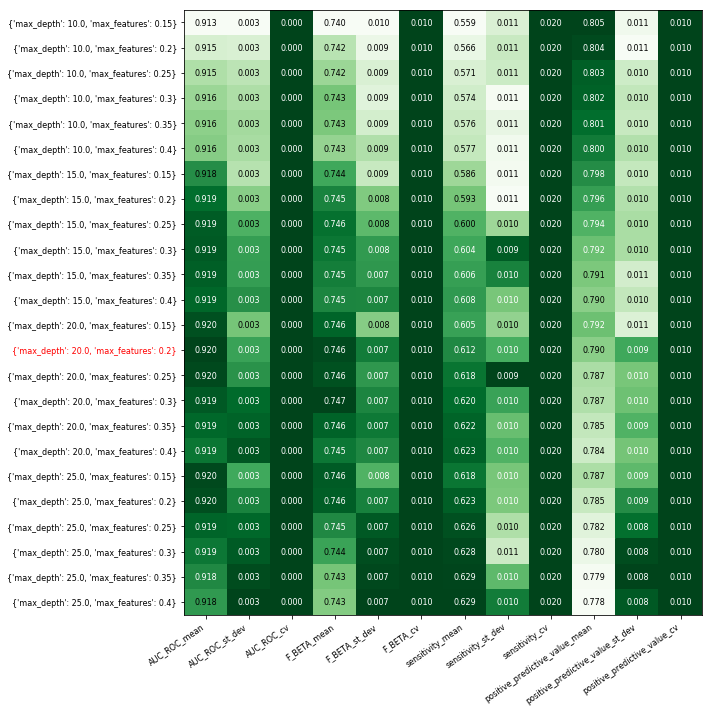

In [17]:
tuner.results.plot_resampled_stats()

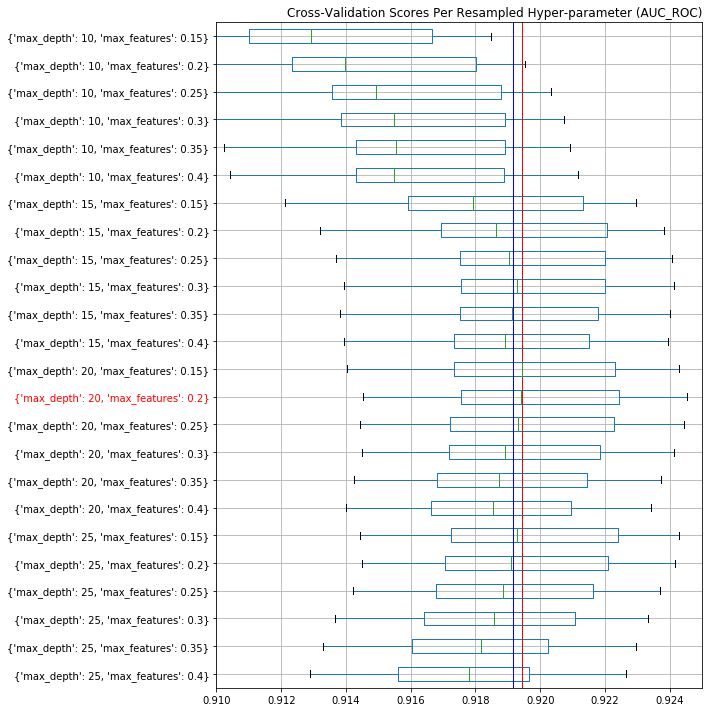

In [18]:
tuner.results.plot_resampled_scores(metric=oo.Metric.AUC_ROC,
                                    x_axis_limits=(0.91, 0.925),
                                    show_one_ste_rule=True
                                   )

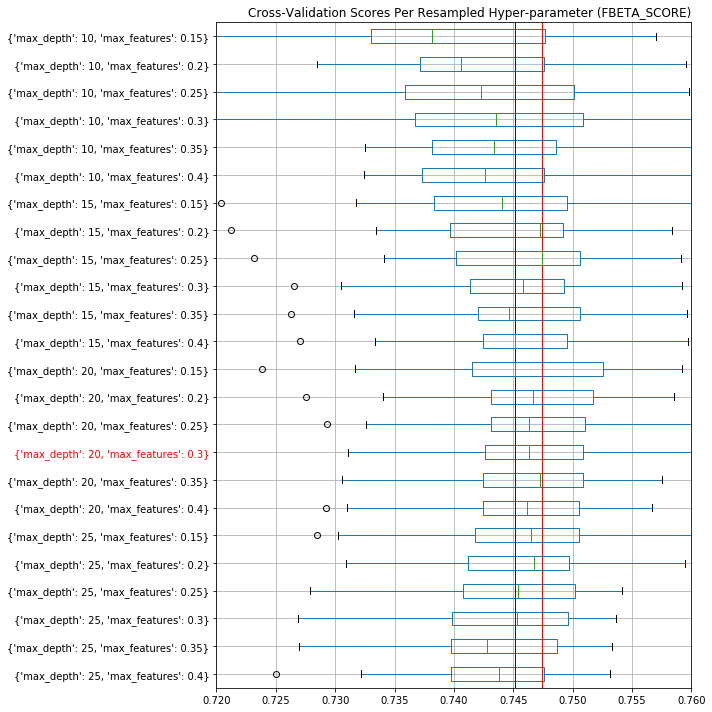

In [19]:
tuner.results.plot_resampled_scores(oo.Metric.FBETA_SCORE,
                                    x_axis_limits=(0.72, 0.76),
                                    show_one_ste_rule=True
                                   )

In [20]:
params_dict

{'max_depth': [10, 15, 20, 25],
 'max_features': [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}

In [21]:
tuner.results.best_hyper_params

{'max_depth': 20, 'max_features': 0.2}

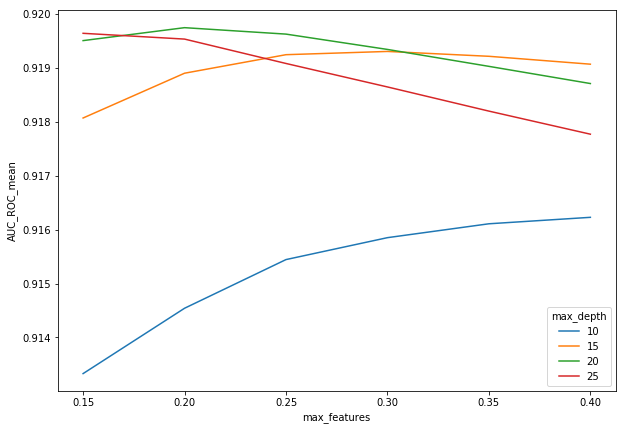

In [22]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='max_features',
                                        line='max_depth',
#                                        grid='min_samples_split'
                                       )

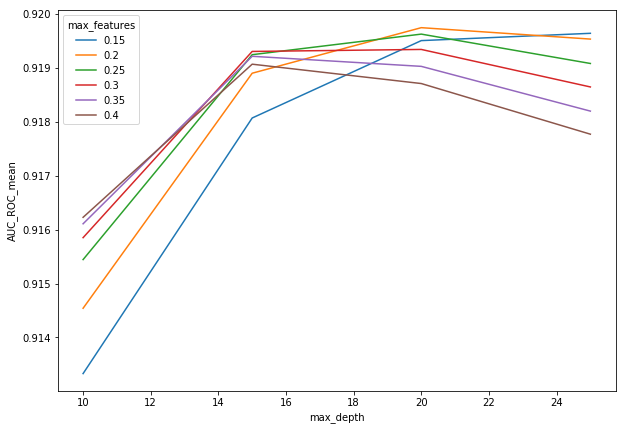

In [23]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='max_depth',
                                        line='max_features',
#                                        grid='min_samples_split'
                                       )

In [24]:
assert False

AssertionError: 

# Retrain on Full Training

In [26]:
final_hyper_param_object = oo.RandomForestHP(
                                                criterion='gini',
                                                num_features=None,
                                                max_features=0.2,
                                                n_estimators=1815,
                                                max_depth=20,
                                                min_samples_split=16,
                                                min_samples_leaf=2,
                                                min_weight_fraction_leaf=0.0,
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0,
                                            )

final_model = oo.RandomForestClassifier()
final_transformations = [
                         # kaggle test file has white space around values
                         oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                                       custom_function=lambda x: x.str.strip()),
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [27]:
# use the ideal threshold for the evaluator in order to view ROC
evaluator = oo.TwoClassProbabilityEvaluator(converter=
                    oo.TwoClassThresholdConverter(positive_class=positive_class))

trainer = oo.ModelTrainer(model=final_model.clone(),
                          model_transformations=[t.clone() for t in final_transformations],
                          splitter=None,  # don't split, train on all data
                          evaluator=evaluator,
                          scores=[s.clone() for s in score_list])
trainer.train(data=explore.dataset, target_variable=target_variable, hyper_params=final_hyper_param_object.clone())

trainer.training_evaluator.all_quality_metrics

{'AUC ROC': 0.9485068881659218,
 'AUC Precision/Recall': 0.8695516931565509,
 'Kappa': 0.6614910460705716,
 'F1 Score': 0.7353381956239384,
 'Two-Class Accuracy': 0.8828446331431604,
 'Error Rate': 0.1171553668568396,
 'True Positive Rate': 0.6566738044254105,
 'True Negative Rate': 0.9573704945022637,
 'False Positive Rate': 0.042629505497736225,
 'False Negative Rate': 0.3433261955745896,
 'Positive Predictive Value': 0.8354143019296254,
 'Negative Predictive Value': 0.8943205536636274,
 'Prevalence': 0.2478439697492371,
 'No Information Rate': 0.7521560302507629,
 'Total Observations': 45222}

In [28]:
trainer.training_scores[0].value

0.9485068881659218

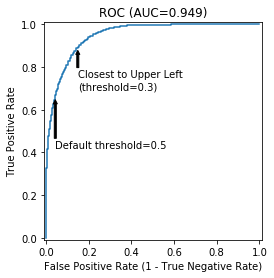

In [29]:
trainer.training_evaluator.plot_roc_curve()

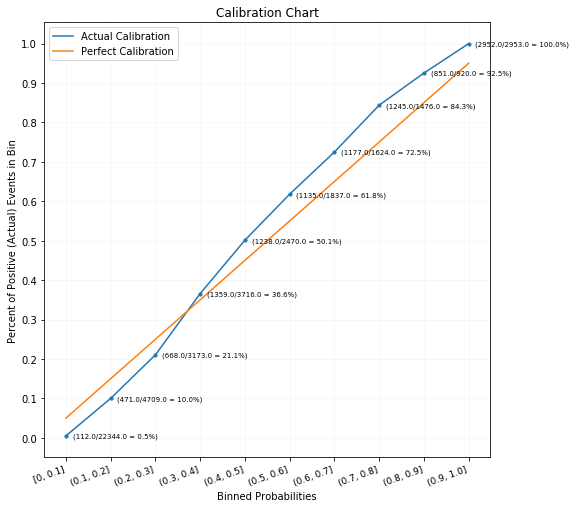

In [32]:
trainer.training_evaluator.plot_calibration()

In [34]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

(45222, 14)

In [35]:
test_dataset.head(100)

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
5,5,52.0,Private,7th-8th,4.0,Divorced,Priv-house-serv,Own-child,Black,Female,0.0,0.0,16.0,United-States
6,6,61.0,Private,7th-8th,4.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,50.0,United-States
7,7,24.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
8,8,30.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,22.0,United-States
9,9,42.0,Local-gov,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States


In [36]:
indexes = test_dataset['Unnamed: 0']

predictions = trainer.predict(test_dataset.drop(columns='Unnamed: 0'))
predictions.head(10)

,<=50K,>50K
0,0.971562,0.028438
1,0.284037,0.715963
2,0.708094,0.291906
3,0.000345,0.999655
4,0.948141,0.051859
5,0.996165,0.003835
6,0.719471,0.280529
7,0.929226,0.070774
8,0.995552,0.004448
9,0.536645,0.463355


In [37]:
income_value = predictions['>50K']
new_predictions = pd.DataFrame({'id': indexes, 'income': income_value})
new_predictions.to_csv('submission_8_RandomForest.csv', index=False)

# Results

## 1)

Kaggle Public: `0.94923`

File: `submission_8_RandomForest.csv`

Parameters: 

```
criterion='gini',
num_features=None,
max_features=0.2,
n_estimators=1815,
max_depth=20,
min_samples_split=16,
min_samples_leaf=2,
min_weight_fraction_leaf=0.0,
max_leaf_nodes=None,
min_impurity_decrease=0,
```

Originally had Mean Resampler Results of:

```
{'AUC_ROC': 0.9197400158190018,
 'F_BETA': 0.7464433451475901,
 'sensitivity': 0.6121649730903619,
 'positive_predictive_value': 0.7898253960602158}
```